In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import dedalus.public as d3

In [3]:
nx = 32 #formerly 32 x 32 x 160? Current plan is 64 x 64 x 320 or 640
ny = 32
nz = 160 # try power of two for nz? e.g. 512?
r = 1
length = 10
dealias = 1
#dealias = 3/2

mesh = None

coords = d3.CartesianCoordinates('x', 'y','z')
dist = d3.Distributor(coords, dtype=np.float64, mesh = mesh)

xbasis = d3.RealFourier(coords['x'], size=nx, bounds=(-r, r), dealias = dealias)
ybasis = d3.RealFourier(coords['y'], size=ny, bounds=(-r, r), dealias = dealias)
zbasis = d3.RealFourier(coords['z'], size=nz, bounds=(0, length), dealias = dealias)

v = dist.VectorField(coords, name='v', bases=(xbasis, ybasis, zbasis))
lnrho = dist.Field(name='lnrho', bases=(xbasis, ybasis, zbasis))
T = dist.Field(name='T', bases=(xbasis, ybasis, zbasis))

x,y,z = dist.local_grids(xbasis,ybasis,zbasis)
rho0 = np.zeros_like(lnrho['g'])

R = r
L = R
lambda_rho = 0.4 # half-width of z transition region for initial conditions
lambda_rho1 = 0.2 #Similar parameter, but used for r-direction transition
rho_min = 0.011
T0 = 0.1
delta = 0.1
max_vel = 0.1

In [4]:
zval = z[0][0]

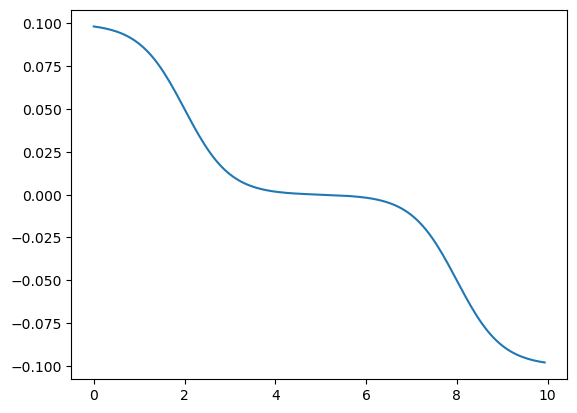

In [5]:
plt.plot(zval,-np.tanh(zval-2)*max_vel/2 + -np.tanh(zval - 8)*max_vel/2)

In [6]:
for i in range(x.shape[0]):
    xVal = x[i,0,0]
    for j in range(y.shape[1]):
        yVal = y[0,j,0]
        for k in range(z.shape[2]):
            zVal = z[0,0,k]
            # v['g'][2] = -np.tanh(6*zVal - 6)*max_vel/2 + -np.tanh(6*zVal - 54)*max_vel/2
            rho0[i][j][k] = -np.tanh(2*zVal-3)*(1-rho_min)/2 -np.tanh(2*(10-zVal)-3)*(1-rho_min)/2 + 1
            
for i in range(x.shape[0]):
    xVal = x[i,0,0]
    for j in range(y.shape[1]):
        yVal = y[0,j,0]
        for k in range(z.shape[2]):
            zVal = z[0,0,k]
            rad = np.sqrt(xVal**2 + yVal**2)
            
            if(rad <= 1 - lambda_rho1):
                rho0[i][j][k] = rho0[i][j][k]
            elif((rad >= 1 - lambda_rho1 and rad <= 1 + lambda_rho1)): # sine arg goes from pi/2 to -pi/2; so this should just generate a curve from rho0 to rhomi_min
                rho0[i][j][k] = (rho0[i][j][k] + rho_min)/2 + (rho0[i][j][k] - rho_min)*np.sin((1-rad) * np.pi/(2*lambda_rho1))/2
            else:
                rho0[i][j][k] = rho_min

In [7]:
lnrho['g'] = np.log(rho0)
T['g'] = T0 * rho0**(5./3. - 1)

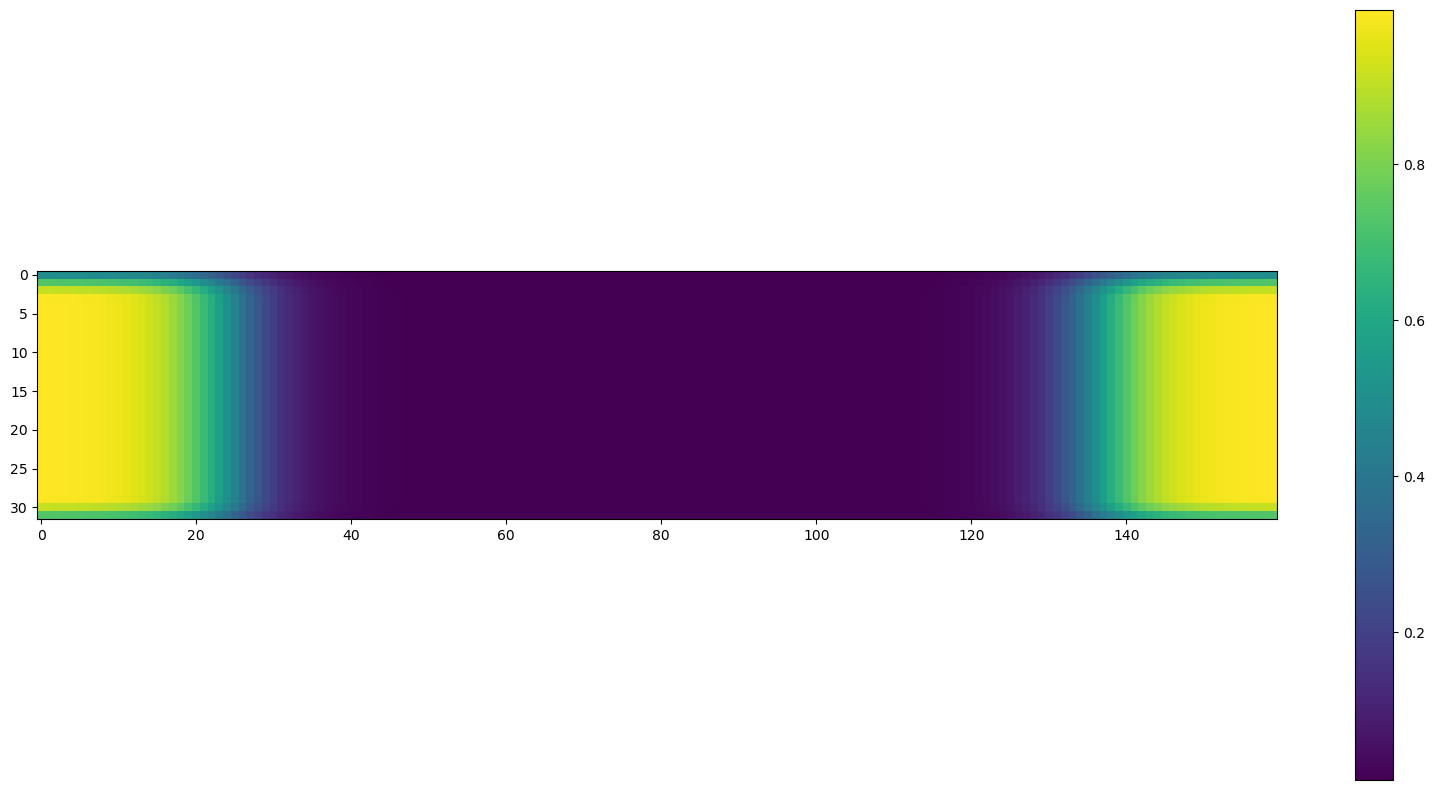

In [27]:
plt.figure(figsize=(20,10)) #make larger
plt.imshow(rho0[:,15,:]) #vmax = 0.01
plt.colorbar()

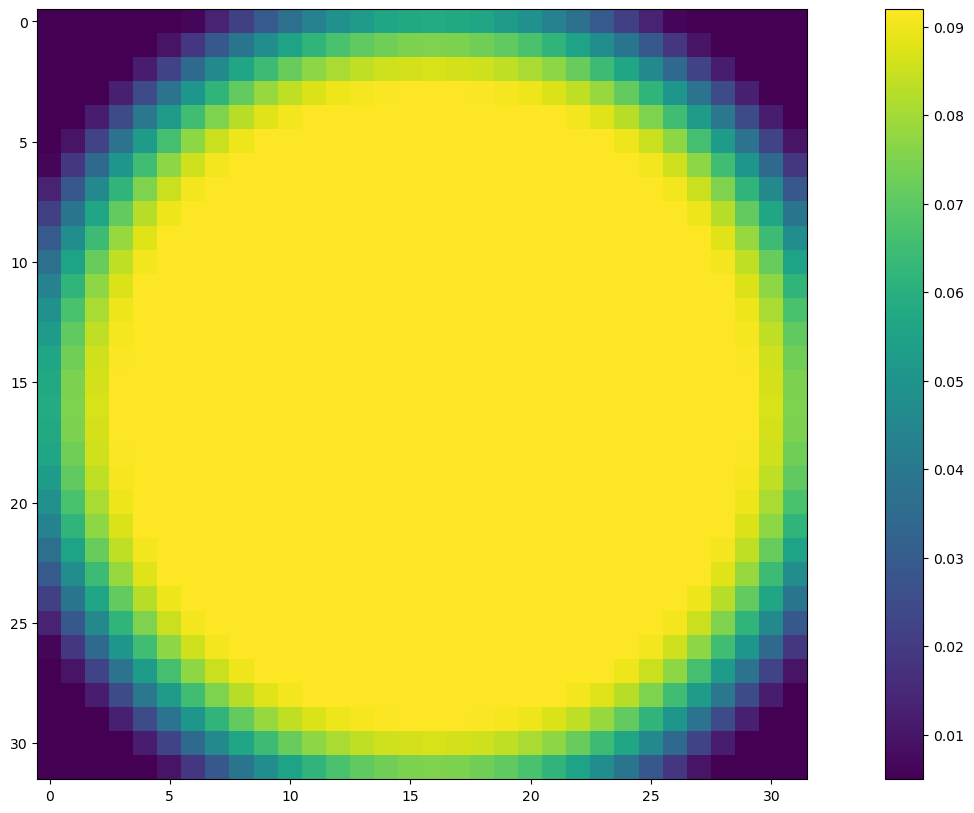

In [23]:
plt.figure(figsize=(20,10)) #make larger
plt.imshow(T['g'][:,:,16]) #vmax = 0.01
plt.colorbar()